In [1]:
from neurovelo.train import Trainer
from neurovelo.utils import ModelAnalyzer,latent_data
import scvelo as scv
import scanpy as sc

In [2]:
adata = scv.datasets.bonemarrow()

Do all preprocessing before running the method.

Abundance of ['unspliced', 'spliced']: [0.48 0.52]


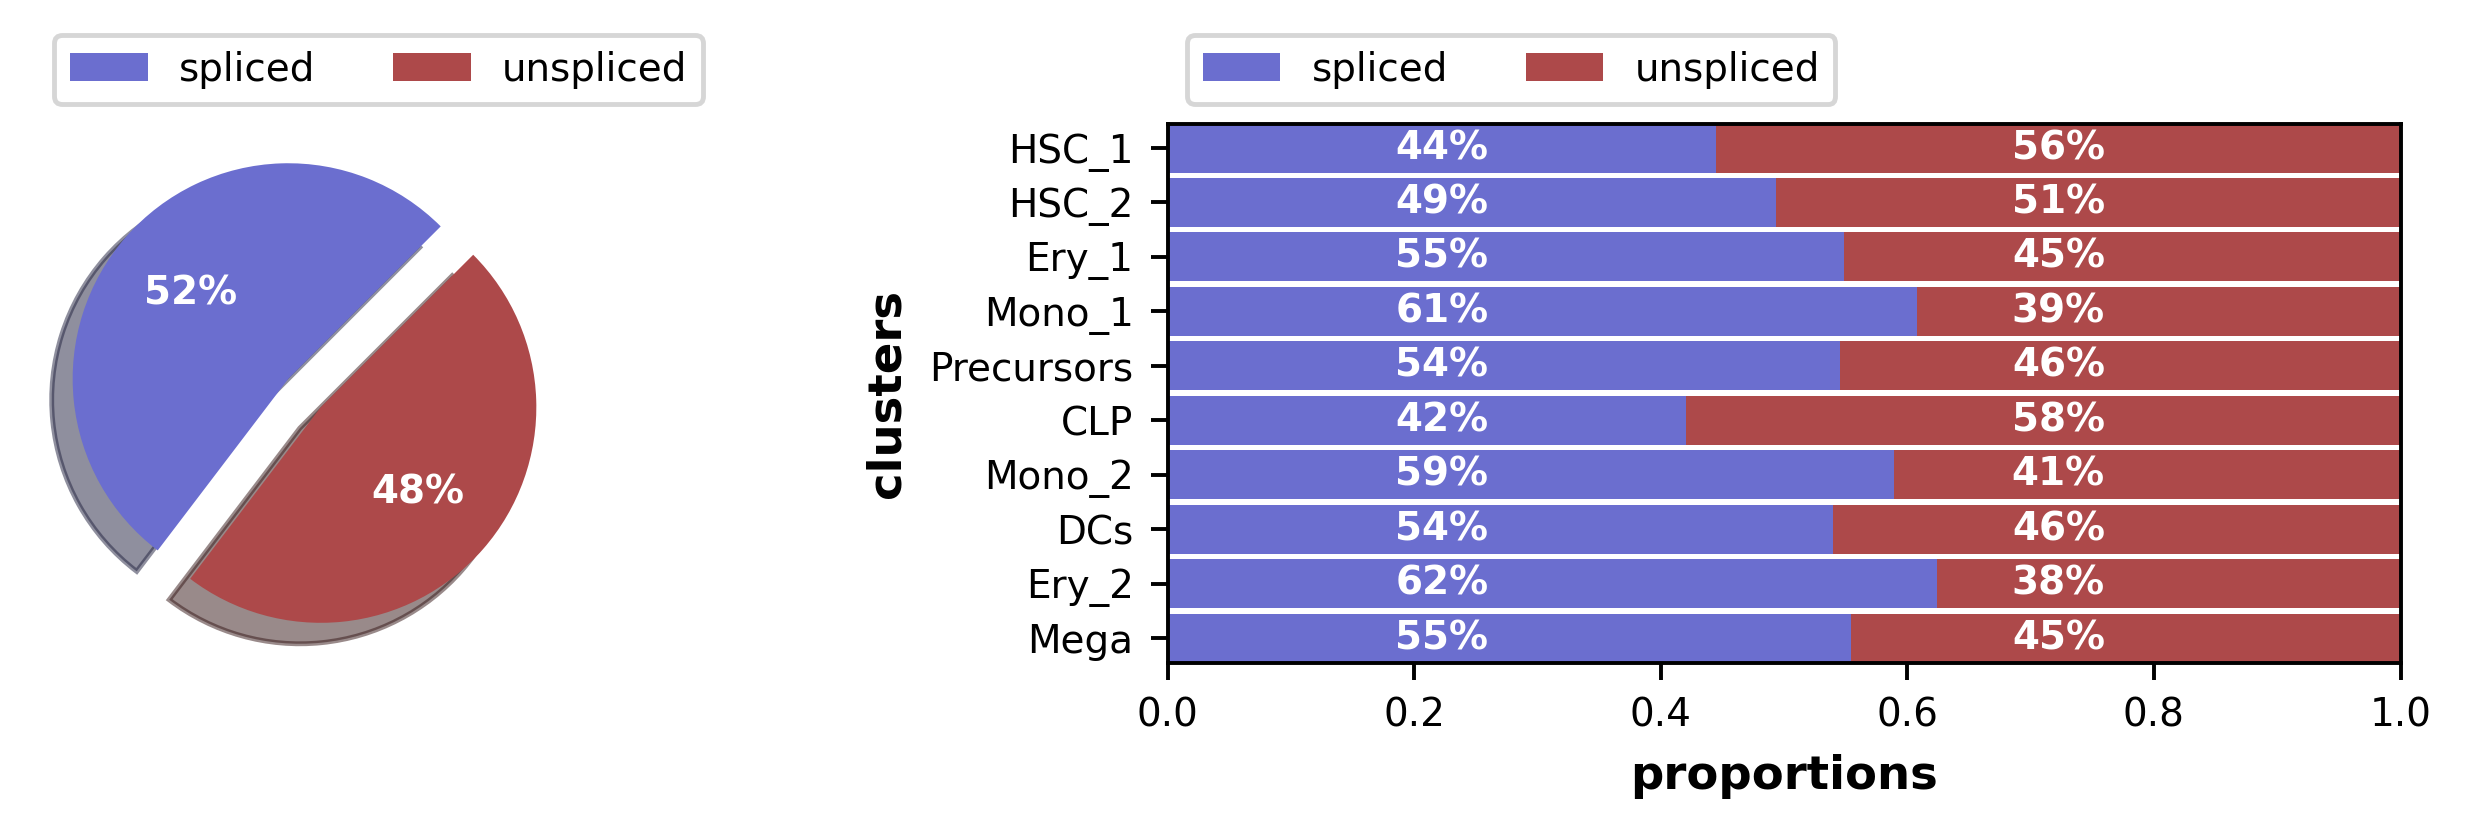

Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


2023-11-21 09:07:17.677952: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 09:07:17.716649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 09:07:19.893221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [3]:
scv.pp.remove_duplicate_cells(adata)
scv.utils.show_proportions(adata)
scv.pl.proportions(adata, dpi=350)
scv.pp.filter_and_normalize(adata, n_top_genes=2000)
scv.pp.moments(adata)

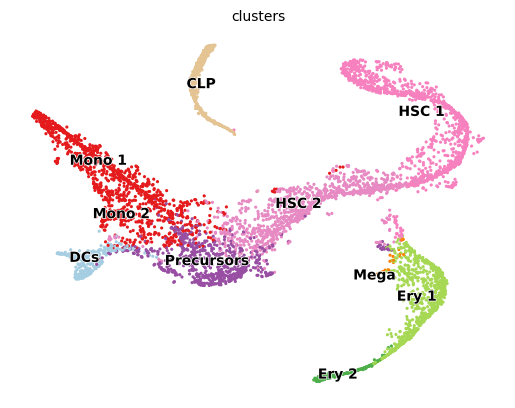

In [4]:
scv.pl.tsne(adata, color='clusters')

**NeuroVelo takes "sample" obs to learn sample specific dynamics. If you want to train for global dynamics of your dataset. Create a sample obs and set it to zero as shown here**

In [5]:
adata.obs['sample'] = 0

***You can pass in layer argument whether you want to use moments (pass 'Ms') or reads (pass 'spliced').
You can also pass all the usual argument to train a neural network.***

In [6]:
model = Trainer(adata,layer='Ms', sample_obs = 'sample', n_sample=1, batch_size=200,nepoch=1000, 
                n_latent=50,n_ode_hidden = 200,n_vae_hidden = 200, percent=0.9,
                use_gpu=False, batch_norm=False, use_pca=True,same_ode=True, random_state=6269)

Using spliced and unspliced moments


In [7]:
model.train()

Epoch 1000: 100%|██████████| 1000/1000 [59:15<00:00,  3.56s/epoch, train_loss=0.0294, val_loss=0.0307]


In [8]:
model.save_model('.','hbm_trained_model_Ms')

In [9]:
latent_adata = latent_data(adata,'hbm_trained_model_Ms.pth', layer='Ms')

In [10]:
scv.pp.neighbors(latent_adata, use_rep='X_z', n_neighbors=30)
latent_adata.obsm['X_tsne'] = adata.obsm['X_tsne']

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_testing_notebook_ms_nolog.png


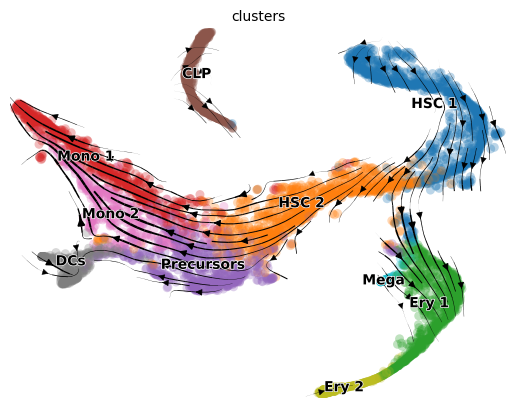

In [11]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', xkey='spliced')
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='tsne')
scv.pl.velocity_embedding_stream(latent_adata,basis='tsne',vkey='spliced_velocity', color='clusters',save='testing_notebook_ms_nolog.png')